## Using SIVP approach to tracking dominant eigenmodes

We initially use temporal stability analysis to find the $\alpha$ mode: 

In [1]:
import os 
import sys
m_path = os.getcwd()
sys.path.append(m_path)

# import all required modules:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
#from mpmath import findroot
from scipy.linalg import lu, solve_triangular, eig
from numpy.linalg import cond

from stream_functions import StreamFunctions
from boundary_conditions import BoundaryConditions
from temporal_stability import TemporalStability

In [2]:

sf = StreamFunctions(n_wakes=1)
bc = BoundaryConditions(sf)
D  = bc.M_non_dim
A = bc.A_non_dim
B = bc.B_non_dim

In [3]:
#val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 'L':0.0, 's':-1, 'c': f'{sf.w}/{sf.alpha}'}
val_set = {'S': 0.2, 'Lambda': -1.1, 'delta': 0.1, 'L':0.0, 's':1}
A_sub = A.subs(val_set)
B_sub = B.subs(val_set)

In [4]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
alpha_r = np.arange(0,20,0.5)
w_vals = np.zeros_like(alpha_r, dtype=complex)
w1_vals = np.zeros_like(alpha_r, dtype=complex)
w2_vals = np.zeros_like(alpha_r, dtype=complex)

for i in range(len(alpha_r)):
    c_val_list, ignore_vals = ts.find_c(alpha_r[i])
    temp_w_vals = c_val_list * alpha_r[i]
    temp_w_vals = temp_w_vals[np.isfinite(temp_w_vals)]
    temp_w_vals = temp_w_vals[np.real(temp_w_vals) < max_threshold]
    if temp_w_vals.shape[0] == 0:
        w_vals[i] = np.nan
        w1_vals[i] = np.nan
        w2_vals[i] = np.nan
    else:
        w1_vals[i] = temp_w_vals[0]
        w2_vals[i] = temp_w_vals[1]
        max_w_val_idx = np.argmax(np.imag(temp_w_vals))
        w_vals[i] = temp_w_vals[max_w_val_idx]

C:\Users\tvivek\AppData\Local\Temp\ipykernel_20952\3862847624.py:10: RuntimeWarning: invalid value encountered in multiply
  temp_w_vals = c_val_list * alpha_r[i]


<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_20952\747466451.py:6: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


Text(0, 0.5, '$\\omega_i$')

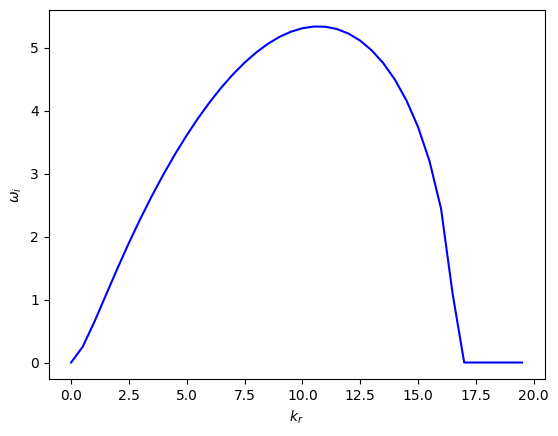

In [5]:
plt.ion()
plt.figure()
plt.plot(alpha_r, np.imag(w_vals), color='blue')
#plt.scatter(alpha_r, np.real(w_vals), color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
C:\Users\tvivek\AppData\Local\Temp\ipykernel_20952\3405403774.py:7: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_i$')


Text(0, 0.5, '$\\omega_i$')

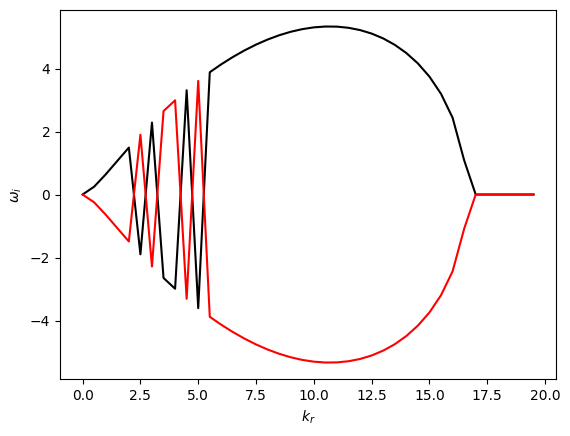

In [6]:
plt.ion()
plt.figure()
plt.plot(alpha_r, np.imag(w1_vals), color='black')
plt.plot(alpha_r, np.imag(w2_vals), color='red')
#plt.scatter(alpha_r, np.real(w_vals), color='blue', marker='x', s=50, label='Varicose mode')
plt.xlabel('$k_r$')
plt.ylabel('$\omega_i$')

Find the maximum of w_vals and corresponding $k_r$. That $k_r$ will serve as the starting point to get the intial guess for saddle point.

In [7]:
max_imag_w_val = np.max(np.imag(w_vals))
max_imag_w_val_idx = np.argmax(np.imag(w_vals))
k_beg = alpha_r[max_imag_w_val_idx]
w_beg = w_vals[max_imag_w_val_idx]
print(f'k_beg = {np.round(k_beg,3)}')
print(f'w_beg = {np.round(w_beg,3)}')

k_beg = 10.5
w_beg = (13.718+5.333j)


Get the eigenpair $(\mathbf{\hat{q}_1}, \omega_1)$ at the $\alpha$ mode location on the real $k$ line

In [8]:
ts = TemporalStability(sf, bc, val_set)
max_threshold = 1e6
c_vals, q1_vals = ts.find_c(k_beg)
filter_for_c_vals = [np.isfinite(c_vals)] and c_vals < max_threshold
q1_vals_filtered = []
for i in range(q1_vals.shape[1]):
    if filter_for_c_vals[i]:
        q1_vals_filtered.append(q1_vals[:,i])
q1_hat = np.array(q1_vals_filtered, dtype=complex)
q1_hat = q1_hat.T
c_vals = c_vals[filter_for_c_vals]
w_vals = c_vals * k_beg
if np.imag(w_vals[0]) > np.imag(w_vals[1]):
    w1 = w_vals[0]
else:
    w1 = w_vals[1]
w_vals

array([13.71787075+5.3334016j, 13.71787075-5.3334016j])

In [9]:
class SIVP:
    def __init__(self, sf, bc, val_set=None):
        self.L = bc.A_non_dim * sf.alpha 
        self.M = bc.B_non_dim
        self.L_dot = None
        self.M_dot = None
        self.q1_hat = sp.symbols('q1_hat')
        self.q2_hat = sp.symbols('q2_hat')
        self.q3_hat = sp.symbols('q3_hat')
        self.q4_hat = sp.symbols('q4_hat')
        self.q_hat = sp.Matrix([self.q1_hat, self.q2_hat, self.q3_hat, self.q4_hat])
        self.q_hat_herm = self.q_hat.H
        self.J = None
        self.J11 = None
        self.J12 = None
        self.J21 = None
        self.J22 = None
        self.b = None
        self.b1 = None
        self.b2 = None
        self.val_set = val_set
        self.sf = sf
        self.bc = bc

        self.set_L_M_derivs()
        self.set_Jacobian_matrix()
        self.set_b()
        #self.sub_all()

    def set_L_M_derivs(self):
        self.L_dot = self.L.diff(sf.alpha)
        self.M_dot = self.M.diff(sf.alpha)

    def set_Jacobian_matrix(self):
        self.J11 = self.L - sf.w * self.M
        self.J12 = -self.M * self.q_hat
        self.J21 = self.q_hat_herm
        self.J22 = sp.zeros(1,1)
        self.J = sp.BlockMatrix([[self.J11, self.J12], [self.J21, self.J22]])

    def set_b(self):
        self.b1 = (sf.w * self.M_dot - self.L_dot) * self.q_hat
        self.b2 = sp.zeros(1,1)
        self.b = sp.Matrix.vstack(self.b1, self.b2)

    def sub_all(self, val_set=None):
        if val_set is None:
            if self.val_set is None:
                raise ValueError("val_set must be provided.")
                return
            else:
                val_set = self.val_set

        self.L_sub = self.L.subs(val_set)
        self.M_sub = self.M.subs(val_set)
        self.L_dot_sub = self.L_dot.subs(val_set)
        self.M_dot_sub = self.M_dot.subs(val_set)
        self.J11_sub = self.J11.subs(val_set)
        self.J12_sub = self.J12.subs(val_set)
        self.J21_sub = self.J21.subs(val_set)
        self.J22_sub = self.J22.subs(val_set)
        self.J_sub = self.J.subs(val_set)
        self.b1_sub = self.b1.subs(val_set)
        self.b2_sub = self.b2.subs(val_set)
        self.b_sub = self.b.subs(val_set)

    def sub_alpha(self, alpha):
        self.L_sub = self.L_sub.subs({'alpha': alpha})
        self.M_sub = self.M_sub.subs({'alpha': alpha})
        self.L_dot_sub = self.L_dot_sub.subs({'alpha': alpha})
        self.M_dot_sub = self.M_dot_sub.subs({'alpha': alpha})
        self.J11_sub = self.J11_sub.subs({'alpha': alpha})
        self.J12_sub = self.J12_sub.subs({'alpha': alpha})
        self.J21_sub = self.J21_sub.subs({'alpha': alpha})
        self.J22_sub = self.J22_sub.subs({'alpha': alpha})
        self.J_sub = self.J_sub.subs({'alpha': alpha})
        self.b1_sub = self.b1_sub.subs({'alpha': alpha})
        self.b2_sub = self.b2_sub.subs({'alpha': alpha})
        self.b_sub = self.b_sub.subs({'alpha': alpha})

    def get_ws_q_hats(self, val_set, alpha):
        L_sub1 = self.L.subs(val_set)
        M_sub1 = self.M.subs(val_set)
        L_sub2 = L_sub1.subs({'alpha': alpha})
        M_sub2 = M_sub1.subs({'alpha': alpha})
        L_num = np.array(L_sub2.evalf()).astype(np.complex128)
        M_num = np.array(M_sub2.evalf()).astype(np.complex128)
        #self.w_vals, self.q_hat_vals = eig(L_num, M_num)
        w_vals, q_hat_vals = eig(L_num, M_num)
        return w_vals, q_hat_vals

    def eval_sub(self, w, q_hat):
        m_val_set = {
            'w':        np.squeeze(w), 
            'q1_hat':   np.squeeze(q_hat[0]), 
            'q2_hat':   np.squeeze(q_hat[1]), 
            'q3_hat':   np.squeeze(q_hat[2]), 
            'q4_hat':   np.squeeze(q_hat[3]),
            }
        self.q_hat_sub = self.q_hat.subs(m_val_set)
        self.q_hat_herm_sub = self.q_hat_herm.subs(m_val_set)
        self.L_sub = self.L_sub.subs(m_val_set)
        self.M_sub = self.M_sub.subs(m_val_set)
        self.L_dot_sub = self.L_dot_sub.subs(m_val_set)
        self.M_dot_sub = self.M_dot_sub.subs(m_val_set)
        self.J11_sub = self.J11_sub.subs(m_val_set)
        self.J12_sub = self.J12_sub.subs(m_val_set)
        self.J21_sub = self.J21_sub.subs(m_val_set)
        self.J22_sub = self.J22_sub.subs(m_val_set)
        self.J_sub = self.J_sub.subs(m_val_set)
        self.b1_sub = self.b1_sub.subs(m_val_set)
        self.b2_sub = self.b2_sub.subs(m_val_set)
        self.b_sub = self.b_sub.subs(m_val_set)

        self.L_num = np.array(self.L_sub.evalf()).astype(np.complex128)
        self.M_num = np.array(self.M_sub.evalf()).astype(np.complex128)
        self.q_hat_num = np.array(self.q_hat_sub.evalf()).astype(np.complex128)
        self.q_hat_herm_num = np.array(self.q_hat_herm_sub.evalf()).astype(np.complex128)
        self.J_num = np.array(self.J_sub.evalf()).astype(np.complex128)
        self.b_num = np.array(self.b_sub.evalf()).astype(np.complex128)
        self.J_num_inv = np.linalg.inv(self.J_num)
        self.L_dot_num = np.array(self.L_dot_sub.evalf()).astype(np.complex128)
        self.M_dot_num = np.array(self.M_dot_sub.evalf()).astype(np.complex128)
    
    def eval_x2(self, x1, dk):
        x2 = np.squeeze(x1) + (self.J_num_inv @ self.b_num.ravel()) * dk
        return x2

    def two_norm_find_matching_x(self, x, ws, q_hats):
        filter_for_ws = [np.isfinite(ws)] and ws < max_threshold
        q_hats_filtered = []
        for i in range(q_hats.shape[1]):
            if filter_for_ws[i]:
                q_hats_filtered.append(q_hats[:,i])
        q_hats = np.array(q_hats_filtered, dtype=complex)
        q_hats = q_hats.T
        ws = ws[filter_for_ws]

        if q_hats.shape[0] == 0:
            print("No valid eigenvalues found.")
            return None
        
        x = np.ravel(x)
        xs = np.vstack((q_hats, ws))
        min_val = np.inf
        idx = 0
        for i in range(xs.shape[1]):
            x_i = np.ravel(xs[:,i])
            #print('x')
            #print(x)
            #print('x_i')
            #print(x_i)
            val = np.linalg.norm(x - x_i)
            #print('x_i - x')
            #print(val)
            if val < min_val:
                min_val = val
                idx = i
        print(f"Minimum value: {min_val}")
        return xs[:,idx]

val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 'L':0.0, 's':1}
sivp = SIVP(sf, bc)
sivp.sub_all(val_set)
sivp.sub_alpha(k_beg)
ws, q_hats = sivp.get_ws_q_hats(val_set, k_beg)
q_hat = q_hats[:,0]
q_hat = q_hat[:, np.newaxis]
w = ws[0]
w = w[np.newaxis]
x1 = np.vstack((q_hat, w))
sivp.eval_sub(ws[0], q_hats[:,0])
k1 = k_beg
k2 = k1 + 0.1j
dk = k2 - k1
x2 = sivp.eval_x2(x1, dk)
#x2

In [10]:
# construct global map of wi(k):
# From the kr value that corresponds to maximum temporal grwoth rate, increment k with dk, dk being imaginary to fill out kr_max + j*ki.
# We are finding each value vertically in the kr-ki plane first and then for each row, we find the left and the right of the known kr_max + j*ki value
# That recovers the entire global map

# some required params
max_threshold = 1e6

# create the wavenumber space
alpha_r = np.arange(0,20,0.5)
alpha_i = np.arange(-20,20,0.5)
alpha_R, alpha_I = np.meshgrid(alpha_r, alpha_i)
w_vals = np.zeros_like(alpha_R, dtype=complex)
visited = np.zeros_like(alpha_R, dtype=bool)

# find the index of maximum growth rate from temporal stability analysis
kr_beg_idx = np.argmin(np.abs(alpha_r - k_beg))
ki_beg_idx = np.argmin(np.abs(alpha_i))
k1 = alpha_R[ki_beg_idx, kr_beg_idx] + 1j * alpha_I[ki_beg_idx, kr_beg_idx]

# mark that index as visited
visited[ki_beg_idx, kr_beg_idx] = True 

# from that index, traverse upward in the alpha_I direction
#curr_imag_idx = ki_beg_idx + 1
#w1 = ws[0]
#q_hat1 = q_hats[:,0]
#k2 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
#dk = k2 - k1

val_set = {'S': 0.2, 'Lambda': -3.1, 'delta': 0.1, 'L':0.0, 's':1}
sivp = SIVP(sf, bc)

def get_matching_x(x1, k1, k2):
    sivp.sub_all(val_set)
    sivp.sub_alpha(k1)
    sivp.eval_sub(x1[-1], x1[:-1])
    x2 = sivp.eval_x2(x1, k2 - k1)
    ws, q_hats = sivp.get_ws_q_hats(val_set, k2)
    #print('DEBUG')
    #print(x2)
    matching_x = sivp.two_norm_find_matching_x(x2, ws, q_hats)
    return matching_x

#x2 = get_matching_x(x1, k2, dk)

# go upward in the ki direction
curr_imag_idx = ki_beg_idx + 1
while curr_imag_idx < alpha_I.shape[0]:
    print(f'curr_imag_idx = {curr_imag_idx}/ {alpha_I.shape[0]}')
    k2 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    x2 = get_matching_x(x1, k1, k2)
    w_vals[curr_imag_idx, kr_beg_idx] = x2[-1]
    visited[curr_imag_idx, kr_beg_idx] = True
    x1 = x2
    k1 = k2
    curr_imag_idx += 1

# go downward in the ki direction
curr_imag_idx = ki_beg_idx - 1
while curr_imag_idx >= 0:
    print(f'curr_imag_idx = {curr_imag_idx}/ {alpha_I.shape[0]}')
    k2 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    x2 = get_matching_x(x1, k1, k2)
    w_vals[curr_imag_idx, kr_beg_idx] = x2[-1]
    visited[curr_imag_idx, kr_beg_idx] = True
    x1 = x2
    k1 = k2
    curr_imag_idx -= 1

curr_imag_idx = 0
while curr_imag_idx < alpha_I.shape[0]:
    print(f'curr_imag_idx = {curr_imag_idx}/ {alpha_I.shape[0]}')
    # go left in the kr direction
    k1 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    curr_real_idx = kr_beg_idx - 1
    while curr_real_idx >= 0:
        print(f'curr_real_idx = {curr_real_idx}/ {alpha_I.shape[1]}')
        k2 = alpha_R[curr_imag_idx, curr_real_idx] + 1j * (alpha_I[curr_imag_idx, curr_real_idx])
        x2 = get_matching_x(x1, k1, k2)
        if x2 is None:
            w_vals[curr_imag_idx, curr_real_idx] = np.nan
        else:
            w_vals[curr_imag_idx, curr_real_idx] = x2[-1]
            x1 = x2
        k1 = k2
        visited[curr_imag_idx, curr_real_idx] = True
        curr_real_idx -= 1
    # go right in the kr direction
    k1 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
    curr_real_idx = kr_beg_idx + 1
    while curr_real_idx < alpha_I.shape[1]:
        print(f'curr_real_idx = {curr_real_idx}/ {alpha_I.shape[1]}')
        k2 = alpha_R[curr_imag_idx, kr_beg_idx] + 1j * (alpha_I[curr_imag_idx, kr_beg_idx])
        x2 = get_matching_x(x1, k1, k2)
        if x2 is None:
            w_vals[curr_imag_idx, curr_real_idx] = np.nan
        else:
            w_vals[curr_imag_idx, curr_real_idx] = x2[-1]
            x1 = x2
        k1 = k2
        visited[curr_imag_idx, curr_real_idx] = True
        curr_real_idx += 1
    curr_imag_idx += 1
    


# contourf plot the map and verify its correctness

curr_imag_idx = 41/ 80
Minimum value: 1.443353065921872
curr_imag_idx = 42/ 80
Minimum value: 0.06480958226679054
curr_imag_idx = 43/ 80
Minimum value: 0.06843621764119821
curr_imag_idx = 44/ 80
Minimum value: 1.4112882646051192
curr_imag_idx = 45/ 80
Minimum value: 1.1772322482987296
curr_imag_idx = 46/ 80
Minimum value: 1.9837485857593469
curr_imag_idx = 47/ 80
Minimum value: 1.9212366479654293
curr_imag_idx = 48/ 80
Minimum value: 0.47485832863378225
curr_imag_idx = 49/ 80
Minimum value: 1.1550817146546468
curr_imag_idx = 50/ 80
Minimum value: 1.6746377595525956
curr_imag_idx = 51/ 80
Minimum value: 1.9936428712263818
curr_imag_idx = 52/ 80
Minimum value: 0.20290476724005177
curr_imag_idx = 53/ 80
Minimum value: 1.0145729270905433
curr_imag_idx = 54/ 80
Minimum value: 1.9803192003497907
curr_imag_idx = 55/ 80
Minimum value: 1.6497479537449045
curr_imag_idx = 56/ 80
Minimum value: 1.9028604354397172
curr_imag_idx = 57/ 80
Minimum value: 0.23325710869770563
curr_imag_idx = 58/ 80
Mini

C:\Users\tvivek\AppData\Local\Temp\ipykernel_20952\2192894173.py:130: RuntimeWarning: invalid value encountered in less
  filter_for_ws = [np.isfinite(ws)] and ws < max_threshold


Minimum value: 22.81220178553845
curr_real_idx = 23/ 40
Minimum value: 0.0
curr_real_idx = 24/ 40
Minimum value: 0.0
curr_real_idx = 25/ 40
Minimum value: 0.0
curr_real_idx = 26/ 40
Minimum value: 0.0
curr_real_idx = 27/ 40
Minimum value: 0.0
curr_real_idx = 28/ 40
Minimum value: 0.0
curr_real_idx = 29/ 40
Minimum value: 0.0
curr_real_idx = 30/ 40
Minimum value: 0.0
curr_real_idx = 31/ 40
Minimum value: 0.0
curr_real_idx = 32/ 40
Minimum value: 0.0
curr_real_idx = 33/ 40
Minimum value: 0.0
curr_real_idx = 34/ 40
Minimum value: 0.0
curr_real_idx = 35/ 40
Minimum value: 0.0
curr_real_idx = 36/ 40
Minimum value: 0.0
curr_real_idx = 37/ 40
Minimum value: 0.0
curr_real_idx = 38/ 40
Minimum value: 0.0
curr_real_idx = 39/ 40
Minimum value: 0.0
curr_imag_idx = 41/ 80
curr_real_idx = 20/ 40
Minimum value: 1.5968560562300487
curr_real_idx = 19/ 40
Minimum value: 1.80236600866098
curr_real_idx = 18/ 40
Minimum value: 1.7100629874050166
curr_real_idx = 17/ 40
Minimum value: 2.0011756753885717
curr

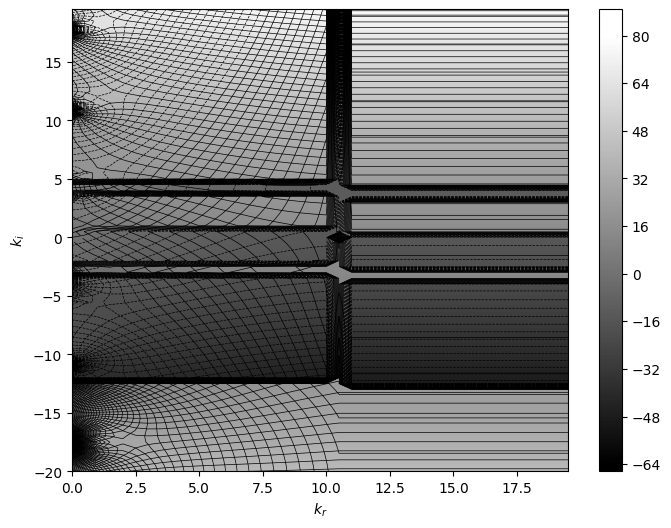

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
cs = ax.contourf(alpha_R, alpha_I, np.imag(w_vals), levels=250)
cbar = plt.colorbar(cs)
cs.set_clim(-64, 80)
ax.contour(alpha_R, alpha_I, np.imag(w_vals), levels=100, colors='black', linewidths=0.5)
ax.contour(alpha_R, alpha_I, np.real(w_vals), levels=100, colors='black', linewidths=0.5)
# set colormap to jet
cs.set_cmap('gray')
ax.set_xlabel('$k_r$')
ax.set_ylabel('$k_i$')
#ax.set_xlim(0, 3.5)
#ax.set_ylim(-4, 4)
plt.ion()
plt.show()

In [21]:
import scipy.io as sio
sio.savemat('C:\\Users\\tvivek\\Desktop\\w_vals_imag_sivp.mat', {'w_vals': w_vals, 'alpha_R': alpha_R, 'alpha_I': alpha_I})